# Analytics

#### Date: 2020/02

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2021/01
##### Professor: Hilmer Neri

##### Members:

- Lorrany Azevedo
- Guilherme Guy
- Alexandre 

### LIBRARIES

In [855]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML

### GRAPH SETTINGS

In [856]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [857]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

In [858]:
repos = [
    '2021.1-Cartografia-social-api-comunidades',
    '2021.1-Cartografia-social-api-gateway',
    '2021.1-Cartografia-social-api-mapas',
    '2021.1-Cartografia-social-api-midia',
    '2021.1-Cartografia-social-api-users'
    #'2021.1-Cartografia-social-front'
]

language = [['2021.1-Cartografia-social-api-comunidades', 'ts'], 
            ['2021.1-Cartografia-social-api-gateway', 'ts'], 
            ['2021.1-Cartografia-social-api-mapas', 'ts'], 
            ['2021.1-Cartografia-social-api-midia', 'ts'], 
            ['2021.1-Cartografia-social-api-users', 'ts']] 
            #['2021.1-Cartografia-social-front', 'js']]

repos_language = {}

for item in language:
    repos_language[f"{item[0]}"] = item[1]

In [859]:
repos_language

{'2021.1-Cartografia-social-api-comunidades': 'ts',
 '2021.1-Cartografia-social-api-gateway': 'ts',
 '2021.1-Cartografia-social-api-mapas': 'ts',
 '2021.1-Cartografia-social-api-midia': 'ts',
 '2021.1-Cartografia-social-api-users': 'ts'}

##### Path to the folder with all your jsons

In [860]:
jsons = glob('**/*.json') # add the path here

In [861]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"fga-eps-mds-2021_1-(.*?)_(.*?)_(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[3]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [862]:
base_component_df = create_base_component_df(jsons)
#print(base_component_df)

In [863]:
#base_component_df.head(50)

#### Create dataframe per file

In [864]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [865]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'ts')

        file_component_df['filename'] = os.path.basename(i)

        df = df.append(file_component_df, ignore_index=True)
        
    # replace TeamName by yours.    
    aux_df = df['filename'].str.split(r"fga-eps-mds-2021_1-(.*?)_(.*?)_(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[3]
    
    df = df.sort_values(by=['repository', 'version'])

    df.to_csv('result2.csv')
    
    return df

In [866]:
file_component_df = create_file_df(jsons)


In [867]:
#print(file_component_df['version'])
file_component_df = file_component_df.sort_values(by='version')
#print(file_component_df)

In [868]:
#file_component_df.head(100)
file_component_df.repository.unique()

array(['Cartografia-social-api-comunidades',
       'Cartografia-social-api-mapas', 'Cartografia-social-api-users',
       'Cartografia-social-api-gateway', 'Cartografia-social-api-midia'],
      dtype=object)

#### Create dataframe per repository

In [869]:
repository_dataframes = {} 

for repository in repos:
    df = file_component_df[file_component_df['repository'] == f"{repository}"]
    df.name = f"{repository}"
    repository_dataframes[f"{repository}"] = df
    
repository_dataframes.keys()

dict_keys(['2021.1-Cartografia-social-api-comunidades', '2021.1-Cartografia-social-api-gateway', '2021.1-Cartografia-social-api-mapas', '2021.1-Cartografia-social-api-midia', '2021.1-Cartografia-social-api-users'])

In [870]:
api_comunidades_df = file_component_df[file_component_df['repository'] == 'Cartografia-social-api-comunidades']
api_gateway_df = file_component_df[file_component_df['repository'] == 'Cartografia-social-api-gateway']
api_mapas_df = file_component_df[file_component_df['repository'] == 'Cartografia-social-api-mapas']
api_midia_df = file_component_df[file_component_df['repository'] == 'Cartografia-social-api-midia']
api_users_df = file_component_df[file_component_df['repository'] == 'Cartografia-social-api-users']
#front_df = file_component_df[file_component_df['repository'] == '2021.1-Cartografia-social-api-front']
#print(api_comunidades_df)

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [871]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [872]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [873]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

In [874]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        ncloc += int(each)
    
    return ncloc

# Quality Aspect - Reliability
## Factor - Testing Status

##### Passed tests

In [875]:
def m4(df):

    passed_tests = df['test_success_density'].astype(float).median() / 100

    return passed_tests

##### Fast test builds

In [876]:
def m5(df):

    density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / sum(df['tests'].astype(float))

    return density_fast_test_builds

##### Test coverage

In [877]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [878]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m3(version_df))
        m5_list.append(m3(version_df))
        m6_list.append(m3(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m3_list,
                               'm5': m3_list,
                               'm6': m3_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list
                              })
        
    return metrics_df

In [879]:
repository_metrics = {}

for repository, repo_df in repository_dataframes.items():   
    metrics_df = create_metrics_df(repo_df)
    metrics_df.name = f"{repository}"
    repository_metrics[f"{repository}"] = metrics_df
    
repository_dataframes.keys()

dict_keys(['2021.1-Cartografia-social-api-comunidades', '2021.1-Cartografia-social-api-gateway', '2021.1-Cartografia-social-api-mapas', '2021.1-Cartografia-social-api-midia', '2021.1-Cartografia-social-api-users'])

In [880]:
api_comunidades_metrics = create_metrics_df(api_comunidades_df)
api_gateway_metrics = create_metrics_df(api_gateway_df)
api_mapas_metrics = create_metrics_df(api_mapas_df)
api_midia_metrics = create_metrics_df(api_midia_df)
api_users_metrics = create_metrics_df(api_users_df)
#front_metrics = create_metrics_df(front_df)
...

Ellipsis

In [881]:
all_metrics = pd.concat([api_comunidades_metrics, api_gateway_metrics, api_mapas_metrics, api_midia_metrics, api_users_metrics], ignore_index=True)

# Visualização dos Dados de [Maintainability e Reliability] 

- De cada repositório do nosso micro-serviço

## Análise de estatistica descritiva

- Realiza o cálculo de dados estatísticos de medidas de tendência central, como média, mediana, moda e percentis. Já as medidas de dispersão são o mínimo, máximo, desvio padrão e variância.Esta fase é a fase inicial da nossa análise de dados para descrever e resumir os nossos dados análisados.

Interpretando os dados:

- Média: Média dos valores do conjunto de dados
- Mediana: A mediana é o valor da váriavel que ocupa posição central do conjunto de dados ordenado. Na tabela de análise descritiva o valor 50% é o valor da mediana, e os valores de 75% e 25% são os percentis superiores e inferiores respectivamente, para uma melhor visualização ao fim da tabela foi adicionado um campo chamado mediana, porém o mesmo é igual ao valor de 50% já apresentado.
- Moda: Valor mais recorrente do conjunto de dados.
- Máximo: Maior valor do conjunto de dados
- Desvio padrão (std): Indica a dispersão do conjunto de dados, quanto mais próximo esse valor estiver de 0 mais homogêneo é o conjunto.
- Variância: Menor valor do conjunto de dados.
- Percentis: Os percentis incluidos na saída estão entre 0 e 1 e retornam o percentis de 25%, 50% e 75%

In [882]:
def descriptive_statistics(df):
    #Gera uma estatísticas descritivas excluindo NaN values
    metrics = df.describe()
    
    
    median = df.median()
  
    variance = df.var()
    variance_df = pd.DataFrame({"var": variance,
                               "median": median})
    
    variance_df = variance_df.T
    
    return metrics.append(variance_df).T

## Matriz de Correlação

* Duas estátisticas estão correlacionadas quando existe qualquer associação estatística entre elas, essa correlação pode ser o quão porximas duas váriavéis estão de ter uma relação linear entre si. Aqui usamos a correlação de Pearson onde os valores de r vão de -1 a 1, essa correlação é positiva quando r > 0, isso significa que ambas as váriaveis se movem na mesmas direção, ou essa correlação pode ser negativa (r < 0), que é quando as váriaveis andam em direções opostas.

- Correlação positiva: ambas as variáveis mudam na mesma direção. (r > 0)
 - Correlação Nula: Nenhuma relação na mudança das variáveis. (r = 0 ou Nulo)
- Correlação Negativa: as variáveis mudam em direções opostas. (r < 0)

* Pela fórmula a correlação é um número entre -1 e 1 e interpretamos da seguinte maneira: quanto mais o r estiver próximo de 1 ou -1 mais forte será a correlação.

https://rstudio-pubs-static.s3.amazonaws.com/437792_df39a5ff0a55491fb71f0f4a0f5cd0bf.html

In [883]:
def correlationMatrix(df):
    corrMatrix = df.corr(method='pearson')
    return corrMatrix

### Percentis Table

Medida que divide uma amostra de dados ordenados de forma crescente em 100 partes. Calculamos o percentis de 0% a 99% da amostra para cada métrica pois assim poderemos analisar por exemplo em quantos porcento determinado tempo é levado para executar a build de teses. 

In [884]:
def descriptive_per(df):
    #Gera uma estatísticas descritivas excluindo NaN values
    metrics = df.describe(percentiles=[0.0, 0.10, 0.20, 0.30, 0.40, 0.60, 0.70, 0.80, 0.99])
    metrics = metrics.drop(index=['count', 'std', 'mean', 'min', 'max'])
    return metrics

### Gráfico Box-Plot

- colocar descrição

In [885]:
def generate_box(df, repository):
    np.random.seed(1234)
    df = pd.DataFrame(np.random.randn(10, 6),
                      columns=['m1', 'm2', 'm3', 'm4', 'm5', 'm6'])
    
    plt.title(f"{repository}")
    boxplot = df.boxplot(column=['m1', 'm2', 'm3', 'm4', 'm5', 'm6'])
    

In [886]:
#plot history
def plot_history(df, repository):
    
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:COMPLEXITY")
    plt.plot(df['m1'], linewidth=3, marker='o', markersize=10)
    
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:COMMENTS")
    plt.plot(df['m2'], linewidth=3, marker='o', markersize=10)
    
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:DUPLICATIONS")
    plt.plot(df['m3'], linewidth=3, marker='o', markersize=10)
    
#    fig = plt.figure(figsize=(20, 10))
#    plt.title(f"{repository}:PASSED TESTS")
#    plt.plot(df['m4'], linewidth=3, marker='o', markersize=10)
    
#    fig = plt.figure(figsize=(20, 10))
#    plt.title(f"{repository}:FAST TESTS BUILD")
#    plt.plot(df['m4'], linewidth=3, marker='o', markersize=10)

## Análise de  [Maintainability e Reliability] do repositório Cartografia-social-api-comunidades

In [887]:
generic_df = api_comunidades_metrics.copy()
repository = "CARTOGRAFIA-SOCIAL-API-COMUNIDADES"

### Plot do Histórico das métricas - comunidades

In [888]:
#plot_history(generic_df, repository)

### Estatistica descritiva - comunidades

In [889]:
#descriptive_statistics(generic_df)

### Cálculo da moda - comunidades

In [890]:
#generic_df.mode(numeric_only=True)

### Tabela de porcentagem - comunidades

In [891]:
#descriptive_per(generic_df)

### Matriz de correlação - comunidades

In [892]:
#corr_df = correlationMatrix(generic_df)
#plt.figure(figsize=(8, 6))
#sns.heatmap(corr_df, annot=True)
#plt.show()
#corr_df.style.background_gradient(cmap='coolwarm')

### Box-plot - comunidades

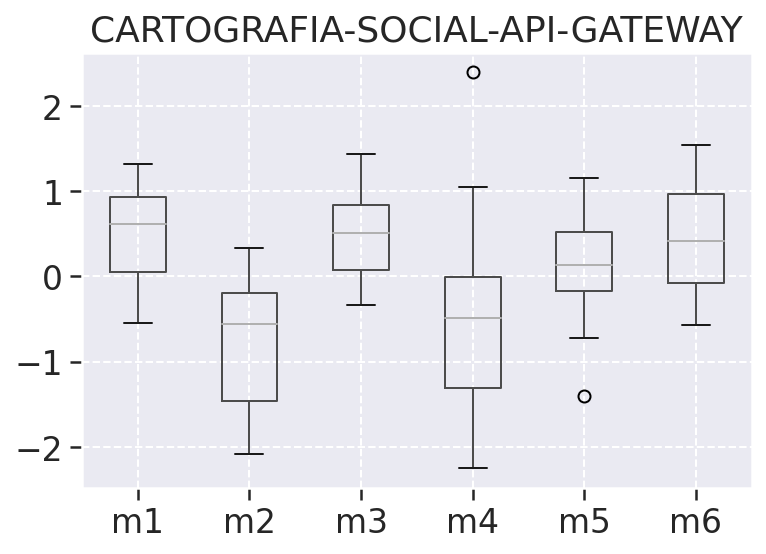

In [942]:
generate_box(generic_df, repository)

## Análise de  [Maintainability e Reliability] do repositório Cartografia-social-api-gateway

In [940]:
generic_df = api_gateway_metrics.copy()
repository = "CARTOGRAFIA-SOCIAL-API-GATEWAY"

### Plot do Histórico das métricas - gateway

In [904]:
#plot_history(generic_df, repository)

### Estatistica descritiva - Gateway

In [906]:
#descriptive_statistics(generic_df)

### Cálculo da moda - Gateway

In [ ]:
#generic_df.mode(numeric_only=True)

### Tabela de porcentagem - Gateway

In [941]:
descriptive_per(generic_df)

,m1,m2,m3,m4,m5,m6,ncloc,code_quality,testing_status
0%,0.250000,0.000000,0.925926,0.925926,0.925926,0.925926,46.0,0.412500,0.925926
10%,0.262500,0.000000,0.940741,0.940741,0.940741,0.940741,133.6,0.433950,0.940741
20%,0.330357,0.000000,1.000000,1.000000,1.000000,1.000000,206.0,0.460821,1.000000
30%,0.367857,0.030000,1.000000,1.000000,1.000000,1.000000,264.8,0.477956,1.000000
40%,0.375000,0.060000,1.000000,1.000000,1.000000,1.000000,350.0,0.492462,1.000000
50%,0.384615,0.071429,1.000000,1.000000,1.000000,1.000000,367.0,0.495000,1.000000
60%,0.416667,0.078205,1.000000,1.000000,1.000000,1.000000,433.2,0.495000,1.000000
70%,0.450000,0.083333,1.000000,1.000000,1.000000,1.000000,454.8,0.512111,1.000000
80%,0.622222,0.108333,1.000000,1.000000,1.000000,1.000000,515.4,0.537778,1.000000
99%,0.964444,0.161667,1.000000,1.000000,1.000000,1.000000,1031.0,0.646800,1.000000


### Matriz de correlação - Gateway

In [910]:
#corr_df = correlationMatrix(generic_df)
#plt.figure(figsize=(8, 6))
#sns.heatmap(corr_df, annot=True)
#plt.show()
#corr_df.style.background_gradient(cmap='coolwarm')

### Box-plot - Gateway

In [912]:
#generate_box(generic_df, repository)

## Análise de  [Maintainability e Reliability] do repositório Cartografia-social-api-mapas


In [913]:
generic_df = api_mapas_metrics.copy()
repository = "CARTOGRAFIA-SOCIAL-API-MAPAS"

### Plot do Histórico das métricas - mapas

In [915]:
#plot_history(generic_df, repository)

### Estatistica descritiva - mapas

In [917]:
#descriptive_statistics(generic_df)

### Cálculo da moda - mapas

In [919]:
#generic_df.mode(numeric_only=True)

### Tabela de percentis - mapas

In [921]:
#descriptive_per(generic_df)

### Matriz de correlação - mapas

In [924]:
#corr_df = correlationMatrix(generic_df)
#plt.figure(figsize=(8, 6))
#sns.heatmap(corr_df, annot=True)
#plt.show()
#corr_df.style.background_gradient(cmap='coolwarm')

### Box-plot - Mapas

In [926]:
#generate_box(generic_df, repository)

## Análise de  [Maintainability e Reliability] do repositório Cartografia-social-api-midia


In [ ]:
generic_df = api_midia_metrics.copy()
repository = "CARTOGRAFIA-SOCIAL-API-MIDIA"

### Plot do Histórico das métricas - midia

In [930]:
#plot_history(generic_df, repository)

### Estatistica descritiva - midia

In [929]:
#descriptive_statistics(generic_df)

### Cálculo da moda - midia

In [932]:
#generic_df.mode(numeric_only=True)

### Tabela de percentis - midia

In [ ]:
#descriptive_per(generic_df)

### Matriz de correlação - midia

In [934]:
corr_df = correlationMatrix(generic_df)
#plt.figure(figsize=(8, 6))
#sns.heatmap(corr_df, annot=True)
#plt.show()
#corr_df.style.background_gradient(cmap='coolwarm')

## Análise de  [Maintainability e Reliability] do repositório Cartografia-social-api-users

In [935]:
generic_df = api_users_metrics.copy()
repository = "CARTOGRAFIA-SOCIAL-API-USERS"

### Plot do Histórico das métricas - Users

In [937]:
#plot_history(generic_df, repository)

### Estatistica descritiva - Users

In [939]:
#descriptive_statistics(generic_df)

### Cálculo da moda - Users

In [ ]:
#generic_df.mode(numeric_only=True)

### Tabela de percentis - Users

In [ ]:
#descriptive_per(generic_df)

### Matriz de correlação - Users

In [ ]:
corr_df = correlationMatrix(generic_df)
#plt.figure(figsize=(8, 6))
#sns.heatmap(corr_df, annot=True)
#plt.show()
#corr_df.style.background_gradient(cmap='coolwarm')

### Sub characteristic aggregation

- You must do this for each of your repositories

In [895]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.15
pm5 = 0.15
pm6 = 0.7

api_comunidades_metrics['code_quality'] = ((api_comunidades_metrics['m1']*pm1) + (api_comunidades_metrics['m2']*pm2) + (api_comunidades_metrics['m3']*pm3)) * psc1
api_gateway_metrics['code_quality'] = ((api_gateway_metrics['m1']*pm1) + (api_gateway_metrics['m2']*pm2) + (api_gateway_metrics['m3']*pm3)) * psc1
api_mapas_metrics['code_quality'] = ((api_mapas_metrics['m1']*pm1) + (api_mapas_metrics['m2']*pm2) + (api_mapas_metrics['m3']*pm3)) * psc1
api_midia_metrics['code_quality'] = ((api_midia_metrics['m1']*pm1) + (api_midia_metrics['m2']*pm2) + (api_midia_metrics['m3']*pm3)) * psc1
api_users_metrics['code_quality'] = ((api_users_metrics['m1']*pm1) + (api_users_metrics['m2']*pm2) + (api_users_metrics['m3']*pm3)) * psc1
...

api_comunidades_metrics['testing_status'] = ((api_comunidades_metrics['m4']*pm4) + (api_comunidades_metrics['m5']*pm5) + (api_comunidades_metrics['m6']*pm6)) * psc2
api_gateway_metrics['testing_status'] = ((api_gateway_metrics['m4']*pm4) + (api_gateway_metrics['m5']*pm5) + (api_gateway_metrics['m6']*pm6)) * psc2
api_mapas_metrics['testing_status'] = ((api_mapas_metrics['m4']*pm4) + (api_mapas_metrics['m5']*pm5) + (api_mapas_metrics['m6']*pm6)) * psc2
api_midia_metrics['testing_status'] = ((api_midia_metrics['m4']*pm4) + (api_midia_metrics['m5']*pm5) + (api_midia_metrics['m6']*pm6)) * psc2
api_users_metrics['testing_status'] = ((api_users_metrics['m4']*pm4) + (api_users_metrics['m5']*pm5) + (api_users_metrics['m6']*pm6)) * psc2

...

Ellipsis

In [896]:
metrics_df = pd.concat([api_comunidades_metrics, api_gateway_metrics, api_mapas_metrics, api_midia_metrics, api_users_metrics], ignore_index=True)
metrics_df['maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['Reliability'] = metrics_df['testing_status'] * pc2
metrics_df['total'] = metrics_df['maintainability'] + metrics_df['Reliability']

In [897]:
#metrics_df

In [898]:
#fig = plt.figure(figsize=(20, 10))


#plt.plot(metrics_df['maintainability'], linewidth=3, marker='o', markersize=5)
#plt.plot(metrics_df['Reliability'], linewidth=3, marker='o', markersize=5)


#plt.ylim(.45,.7)

In [899]:
#fig = plt.figure(figsize=(20, 10))


#plt.plot(metrics_df['total'], linewidth=3, marker='o', markersize=5)


#plt.ylim(.45,.7)


In [900]:
# ANALYSIS_DATE FORMAT: MM-DD-YYYY

metrics_df.to_excel('data/fga-eps-mds-2021_1-Cartografia-Social-ANALYSYS.xlsx', index = False)
metrics_df.to_csv('data/fga-eps-mds-2021_1-Cartografia-Social-ANALYSYS.csv', index = False)